# Pre-process

## 1. Import

In [ ]:
import keras
from keras import backend as K
from keras import callbacks
from keras import layers
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping
# from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing import image
from keras.utils import to_categorical

import matplotlib.image as img
import matplotlib.pyplot as plt

import cv2
import time
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from google.colab.patches import cv2_imshow
from numpy import asarray
from numpy.random import seed
from os import listdir
from os.path import isfile, join
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.utils import resample
from keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img


from tensorflow.keras.utils import to_categorical

import zipfile
from zipfile import ZipFile
%matplotlib inline

from glob import glob
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Read CSV

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Eye disease(1).csv")

## 3. Unzip Data

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/'
path_zip_file = path + 'archive.zip'
path_file = []
with zipfile.ZipFile(path_zip_file, 'r') as zip:
    files = zip.namelist()
    for img in files:
        zip.extract(img)

## 4. Dataframe

In [ ]:
df

,file_name,labels,side,path,same_side_path
0,3240_right.jpg,0,right,/content/ODIR-5K/ODIR-5K/Training Images/3240_...,/content/same_side_image/3240_right.jpg
1,2953_right.jpg,0,right,/content/ODIR-5K/ODIR-5K/Training Images/2953_...,/content/same_side_image/2953_right.jpg
2,3424_right.jpg,0,right,/content/ODIR-5K/ODIR-5K/Training Images/3424_...,/content/same_side_image/3424_right.jpg
3,3244_right.jpg,0,right,/content/ODIR-5K/ODIR-5K/Training Images/3244_...,/content/same_side_image/3244_right.jpg
4,3207_right.jpg,0,right,/content/ODIR-5K/ODIR-5K/Training Images/3207_...,/content/same_side_image/3207_right.jpg
...,...,...,...,...,...
2755,1584_left.jpg,5,left,/content/ODIR-5K/ODIR-5K/Training Images/1584_...,/content/same_side_image/1584_left.jpg
2756,1588_left.jpg,5,left,/content/ODIR-5K/ODIR-5K/Training Images/1588_...,/content/same_side_image/1588_left.jpg
2757,1529_left.jpg,5,left,/content/ODIR-5K/ODIR-5K/Training Images/1529_...,/content/same_side_image/1529_left.jpg
2758,225_left.jpg,5,left,/content/ODIR-5K/ODIR-5K/Training Images/225_l...,/content/same_side_image/225_left.jpg


In [ ]:
df = df.iloc[:,:4]

## 5. Function

In [ ]:
def resize_image(path, dimention = (256,256)):
  image = cv2.imread(path)
  resize = cv2.resize(image, dimention)
  return resize

In [ ]:
def grayscale(path):
  img_gray = cv2.cvtColor(path, cv2.COLOR_BGR2GRAY)
  return img_gray

In [ ]:
def flip(path):
  img_flip = cv2.flip(path, 1)
  return img_flip

In [ ]:
def plot_images(before, after):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Before")
    if len(before.shape) == 3:
        plt.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(before, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("After")
    if len(after.shape) == 3:
        plt.imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(after, cmap='gray')
    plt.axis('off')

    plt.show()

In [ ]:
def report(y_pred,y_test):

  target_name = ["Normals","Diabetes", "Glaucoma", "Cataract", "Age related", "Myopia"]

  # y_pred = model.predict(x_test)
  # y_pred = np.argmax(y_pred, axis = 1)

  conf_matrix = confusion_matrix(y_test,y_pred)
  ConfusionMatrixDisplay(conf_matrix).plot(cmap = "rocket")

  print("==========================================================")
  print(classification_report(y_test,y_pred,target_names = target_name))
  print("==========================================================")


In [ ]:
# %load _utils
# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):

    # Calculate result
    result = model.evaluate(features,labels,verbose=False)

    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)

    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))

    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=128,channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')

    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)

            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

In [ ]:
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
df['image_normal'] = df['path'].apply(lambda x: resize_image(x, (256,256)))
df['image_normal'] = df['image_normal'].map(grayscale)

## 6. Make Flip Image Column

In [ ]:
df['image_flip'] = df['image_normal']

for t in range(df.shape[0]):
  if df["side"][t] == "right":
    df["image_flip"][t] = flip(df['image_normal'][t])
  else:
    continue

<ipython-input-15-b5953621b775>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["image_flip"][t] = flip(df['image_normal'][t])


In [ ]:
df

,file_name,labels,side,path,image_normal,image_flip
0,3240_right.jpg,0,right,/content/ODIR-5K/ODIR-5K/Training Images/3240_...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2953_right.jpg,0,right,/content/ODIR-5K/ODIR-5K/Training Images/2953_...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3424_right.jpg,0,right,/content/ODIR-5K/ODIR-5K/Training Images/3424_...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3244_right.jpg,0,right,/content/ODIR-5K/ODIR-5K/Training Images/3244_...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,3207_right.jpg,0,right,/content/ODIR-5K/ODIR-5K/Training Images/3207_...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
2755,1584_left.jpg,5,left,/content/ODIR-5K/ODIR-5K/Training Images/1584_...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2756,1588_left.jpg,5,left,/content/ODIR-5K/ODIR-5K/Training Images/1588_...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2757,1529_left.jpg,5,left,/content/ODIR-5K/ODIR-5K/Training Images/1529_...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2758,225_left.jpg,5,left,/content/ODIR-5K/ODIR-5K/Training Images/225_l...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## 7. Train, Test, Validate split

### Both side split





In [ ]:
x = np.expand_dims(list(df['image_flip']), axis=-1)
x = asarray(x)

y = list(df['labels'])
y = asarray(y)

#### Split Train, Test, Validate

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

### Each side split

In [ ]:
df_right = df[df["side"] == "right"]
df_left = df[df["side"] == "left"]

#### Right Train, Test, Validate

In [ ]:
x = np.expand_dims(list(df_right['image_normal']), axis=-1)
x = asarray(x)

y = list(df_right['labels'])
y = asarray(y)

In [ ]:
x_train_right, x_test_right, y_train_right, y_test_right = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
x_train_right, x_val_right, y_train_right, y_val_right = train_test_split(x_train_right, y_train_right, test_size=0.1, random_state=42, stratify=y_train_right)

#### Left Train, Test, Validate

In [ ]:
x = np.expand_dims(list(df_left['image_normal']), axis=-1)
x = asarray(x)

y = list(df_left['labels'])
y = asarray(y)

In [ ]:
x_train_left, x_test_left, y_train_left, y_test_left = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
x_train_left, x_val_left, y_train_left, y_val_left = train_test_split(x_train_left, y_train_left, test_size=0.1, random_state=42, stratify=y_train_left)

# Model 1 Resnet50

In [ ]:
ResNet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94765736/94765736 [==============================] - 1s 0us/step


## Both side same train

In [ ]:
model1 = models.Sequential()
model1.add(layers.InputLayer(input_shape=(256, 256, 1)))
model1.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))
model1.add(ResNet_model)
model1.add(layers.MaxPooling2D(2,2,name='max_pool_1'))
model1.add(layers.Dropout(0.25,name='dropout_1'))
model1.add(layers.GlobalAveragePooling2D())
model1.add(layers.Dense(6, activation='softmax'))
model1.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])

Epoch 1/50
70/70 [==============================] - 81s 526ms/step - loss: 1.7058 - acc: 0.4743 - val_loss: 1325753.2500 - val_acc: 0.1647
Epoch 2/50
70/70 [==============================] - 34s 485ms/step - loss: 1.0784 - acc: 0.5924 - val_loss: 486.5638 - val_acc: 0.1727
Epoch 3/50
70/70 [==============================] - 35s 495ms/step - loss: 0.8918 - acc: 0.6586 - val_loss: 377.0617 - val_acc: 0.2651
Epoch 4/50
70/70 [==============================] - 36s 512ms/step - loss: 0.6903 - acc: 0.7271 - val_loss: 1.2613 - val_acc: 0.5622
Epoch 5/50
70/70 [==============================] - 35s 503ms/step - loss: 0.5126 - acc: 0.8013 - val_loss: 1.9395 - val_acc: 0.4297
Epoch 6/50
70/70 [==============================] - 35s 503ms/step - loss: 0.4172 - acc: 0.8488 - val_loss: 0.9704 - val_acc: 0.6586
Epoch 7/50
70/70 [==============================] - 35s 500ms/step - loss: 0.4861 - acc: 0.8362 - val_loss: 2.2355 - val_acc: 0.3333
Epoch 8/50
70/70 [==============================] - 35s 500

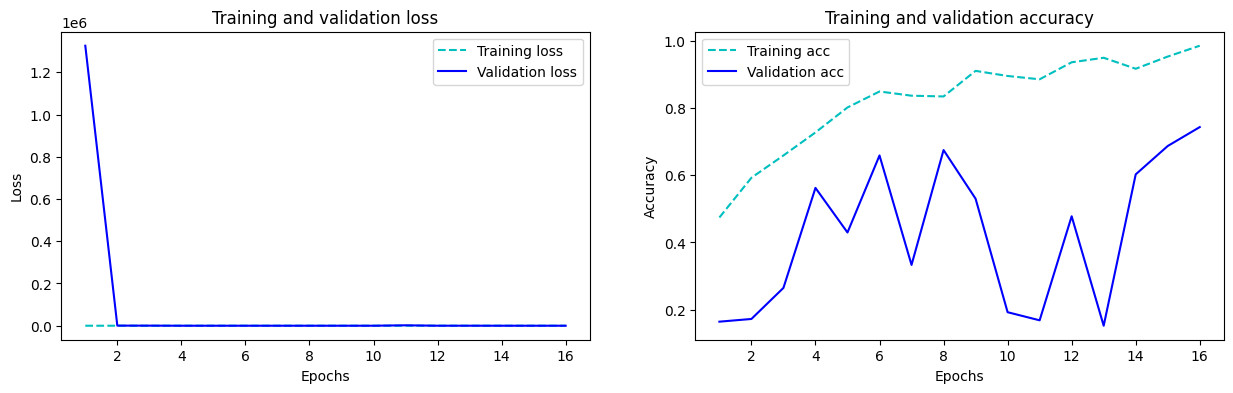

In [ ]:
history_model1 = model1.fit(x_train, y_train,
                            validation_data = (x_val,y_val),
                            batch_size = 32, epochs = 50,
                            callbacks = es)
show_result(history_model1)

In [ ]:
y_pred_resnet = model1.predict(x_test)
y_pred_resnet = np.argmax(y_pred_resnet, axis = 1)

9/9 [==============================] - 3s 240ms/step


              precision    recall  f1-score   support

     Normals       0.41      0.67      0.51        46
    Diabetes       0.73      0.24      0.36        46
    Glaucoma       0.77      0.87      0.82        46
    Cataract       0.88      1.00      0.94        46
 Age related       0.86      0.70      0.77        46
      Myopia       0.95      0.91      0.93        46

    accuracy                           0.73       276
   macro avg       0.77      0.73      0.72       276
weighted avg       0.77      0.73      0.72       276



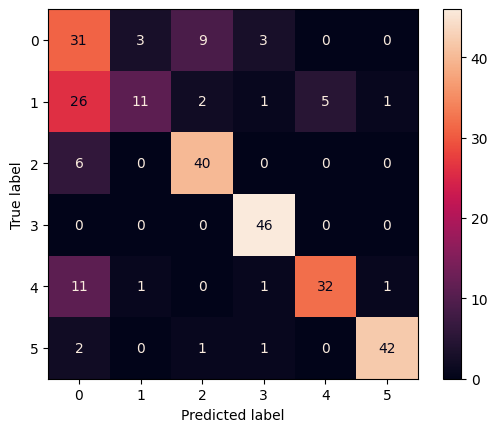

In [ ]:
report(y_pred_resnet, y_test)

## Each side train

### Left side

In [ ]:
model1 = models.Sequential()
model1.add(layers.InputLayer(input_shape=(256, 256, 1)))
model1.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))  # Convert grayscale to RGB
model1.add(ResNet_model)
model1.add(layers.MaxPooling2D(2,2,name='max_pool_1'))
model1.add(layers.Dropout(0.25,name='dropout_1'))
model1.add(layers.GlobalAveragePooling2D())
model1.add(layers.Dense(6, activation='softmax'))  # Output layer
model1.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])

Epoch 1/50
35/35 [==============================] - 51s 598ms/step - loss: 0.5848 - acc: 0.8102 - val_loss: 3.0924 - val_acc: 0.4800
Epoch 2/50
35/35 [==============================] - 18s 518ms/step - loss: 0.1966 - acc: 0.9302 - val_loss: 1.3070 - val_acc: 0.5280
Epoch 3/50
35/35 [==============================] - 18s 510ms/step - loss: 0.1718 - acc: 0.9508 - val_loss: 1.0410 - val_acc: 0.8240
Epoch 4/50
35/35 [==============================] - 18s 503ms/step - loss: 0.3562 - acc: 0.9221 - val_loss: 24.8822 - val_acc: 0.1840
Epoch 5/50
35/35 [==============================] - 18s 504ms/step - loss: 0.3097 - acc: 0.9087 - val_loss: 2972.1375 - val_acc: 0.1680
Epoch 6/50
35/35 [==============================] - 18s 504ms/step - loss: 0.1317 - acc: 0.9570 - val_loss: 130.1597 - val_acc: 0.1760
Epoch 7/50
35/35 [==============================] - 18s 510ms/step - loss: 0.1643 - acc: 0.9606 - val_loss: 65.3329 - val_acc: 0.2240
Epoch 8/50
35/35 [==============================] - 18s 508ms/

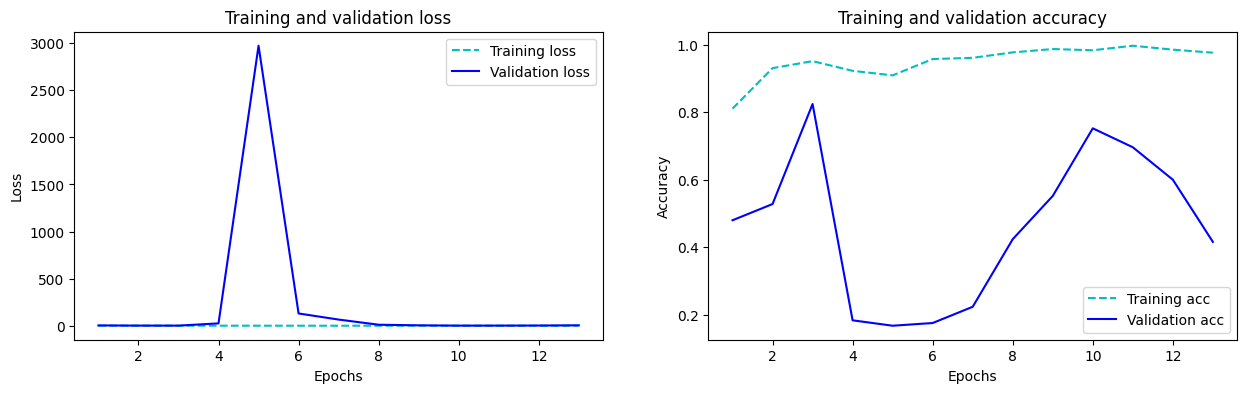

In [ ]:
history_model1_left = model1.fit(x_train_left, y_train_left,
                            validation_data = (x_val_left,y_val_left),
                            batch_size = 32, epochs = 50,
                            callbacks = es)
show_result(history_model1_left)

In [ ]:
y_pred_resnet_left = model1.predict(x_test_left)
y_pred_resnet_left = np.argmax(y_pred_resnet_left, axis = 1)

5/5 [==============================] - 2s 290ms/step


              precision    recall  f1-score   support

     Normals       0.25      0.87      0.39        23
    Diabetes       0.25      0.04      0.07        23
    Glaucoma       0.91      0.43      0.59        23
    Cataract       0.64      1.00      0.78        23
 Age related       1.00      0.09      0.16        23
      Myopia       1.00      0.26      0.41        23

    accuracy                           0.45       138
   macro avg       0.68      0.45      0.40       138
weighted avg       0.68      0.45      0.40       138



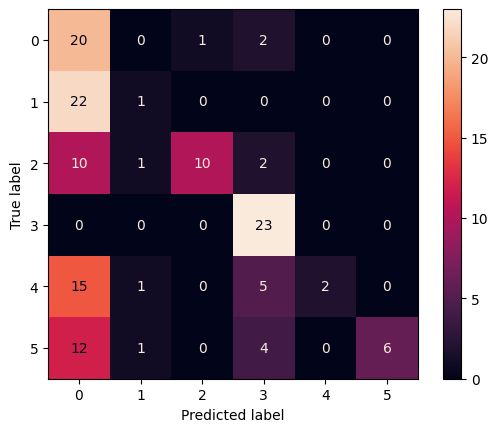

In [ ]:
report(y_pred_resnet_left, y_test_left)

### Right side

In [ ]:
model1 = models.Sequential()
model1.add(layers.InputLayer(input_shape=(256, 256, 1)))
model1.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))  # Convert grayscale to RGB
model1.add(ResNet_model)
model1.add(layers.MaxPooling2D(2,2,name='max_pool_1'))
model1.add(layers.Dropout(0.25,name='dropout_1'))
model1.add(layers.GlobalAveragePooling2D())
model1.add(layers.Dense(6, activation='softmax'))  # Output layer
model1.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])

Epoch 1/50
35/35 [==============================] - 49s 531ms/step - loss: 1.1520 - acc: 0.5586 - val_loss: 1.3349 - val_acc: 0.6080
Epoch 2/50
35/35 [==============================] - 18s 516ms/step - loss: 0.4720 - acc: 0.8326 - val_loss: 0.9378 - val_acc: 0.6480
Epoch 3/50
35/35 [==============================] - 18s 510ms/step - loss: 0.1850 - acc: 0.9400 - val_loss: 0.6701 - val_acc: 0.7760
Epoch 4/50
35/35 [==============================] - 18s 504ms/step - loss: 0.1233 - acc: 0.9678 - val_loss: 1.7397 - val_acc: 0.6160
Epoch 5/50
35/35 [==============================] - 18s 506ms/step - loss: 0.2222 - acc: 0.9257 - val_loss: 1.8750 - val_acc: 0.5360
Epoch 6/50
35/35 [==============================] - 18s 508ms/step - loss: 0.2233 - acc: 0.9320 - val_loss: 0.9517 - val_acc: 0.7200
Epoch 7/50
35/35 [==============================] - 18s 510ms/step - loss: 0.0965 - acc: 0.9740 - val_loss: 1.7124 - val_acc: 0.5920
Epoch 8/50
35/35 [==============================] - 18s 508ms/step - 

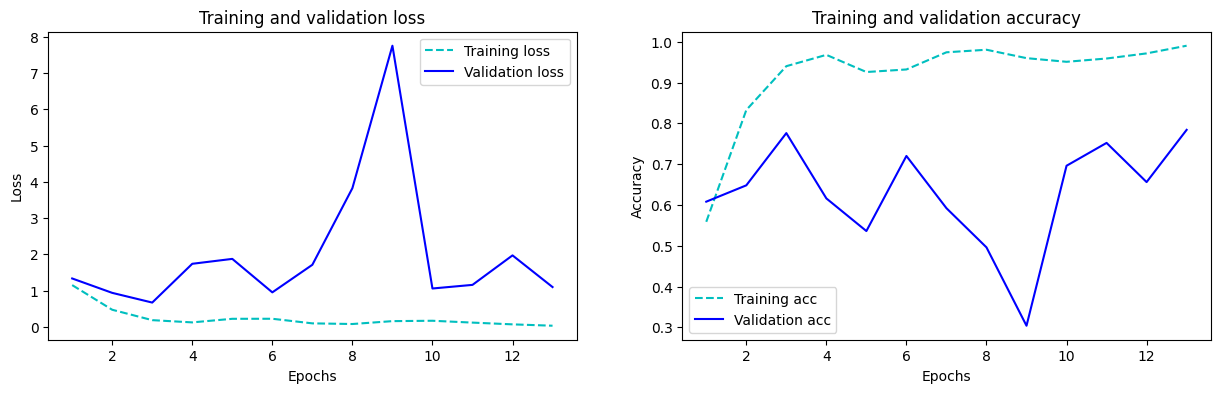

In [ ]:
history_model1_right = model1.fit(x_train_right, y_train_right,
                                  validation_data = (x_val_right,y_val_right),
                                  batch_size = 32, epochs = 50,
                                  callbacks = es)
show_result(history_model1_right)

In [ ]:
y_pred_resnet_right = model1.predict(x_test_right)
y_pred_resnet_right = np.argmax(y_pred_resnet_right, axis = 1)

5/5 [==============================] - 2s 119ms/step


              precision    recall  f1-score   support

     Normals       0.50      0.61      0.55        23
    Diabetes       0.71      0.43      0.54        23
    Glaucoma       0.76      0.96      0.85        23
    Cataract       0.92      1.00      0.96        23
 Age related       1.00      0.48      0.65        23
      Myopia       0.74      1.00      0.85        23

    accuracy                           0.75       138
   macro avg       0.77      0.75      0.73       138
weighted avg       0.77      0.75      0.73       138



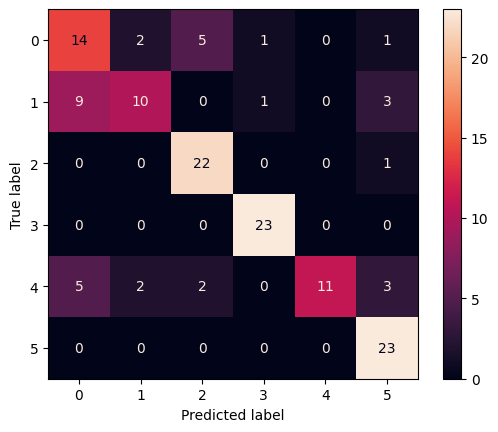

In [ ]:
report(y_pred_resnet_right, y_test_right)

# Model 2 MobileNet

In [ ]:
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=(256, 256, 3),
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

4334752/4334752 [==============================] - 0s 0us/step


## Both side same train

In [ ]:
model_mobilenet = models.Sequential()
model_mobilenet.add(layers.InputLayer(input_shape=(256, 256, 1)))
model_mobilenet.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))
model_mobilenet.add(mobilenet)
model_mobilenet.add(layers.GlobalAveragePooling2D())
model_mobilenet.add(layers.Dense(6, activation='softmax'))
model_mobilenet.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])

Epoch 1/50
70/70 [==============================] - 9s 69ms/step - loss: 1.4045 - acc: 0.4649 - val_loss: 1.1243 - val_acc: 0.5944
Epoch 2/50
70/70 [==============================] - 2s 31ms/step - loss: 1.0703 - acc: 0.5969 - val_loss: 1.0254 - val_acc: 0.5944
Epoch 3/50
70/70 [==============================] - 2s 27ms/step - loss: 0.9854 - acc: 0.6201 - val_loss: 0.9579 - val_acc: 0.6466
Epoch 4/50
70/70 [==============================] - 2s 25ms/step - loss: 0.9327 - acc: 0.6425 - val_loss: 0.9431 - val_acc: 0.6627
Epoch 5/50
70/70 [==============================] - 2s 27ms/step - loss: 0.9028 - acc: 0.6488 - val_loss: 0.9085 - val_acc: 0.7028
Epoch 6/50
70/70 [==============================] - 2s 27ms/step - loss: 0.8694 - acc: 0.6685 - val_loss: 0.8904 - val_acc: 0.6988
Epoch 7/50
70/70 [==============================] - 2s 26ms/step - loss: 0.8506 - acc: 0.6779 - val_loss: 0.8959 - val_acc: 0.6506
Epoch 8/50
70/70 [==============================] - 2s 27ms/step - loss: 0.8314 - a

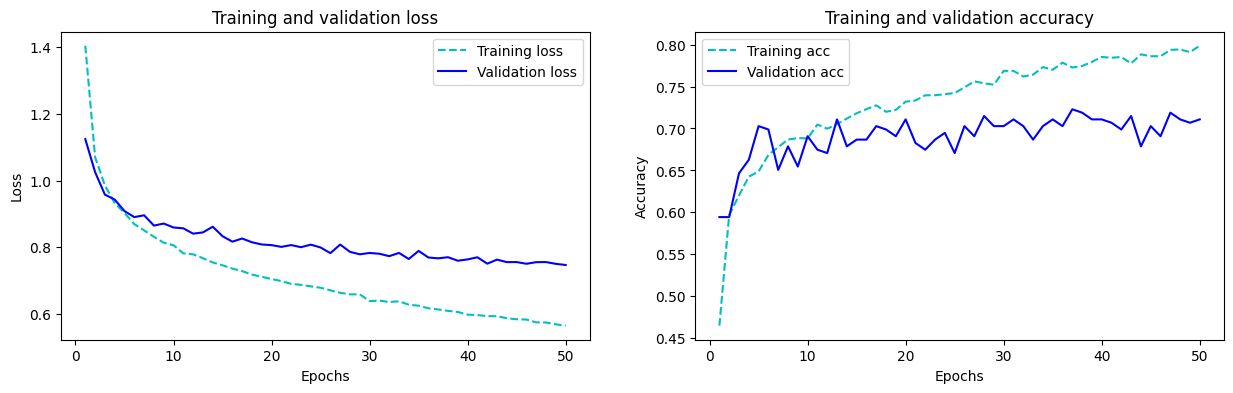

In [ ]:
history_mobilenet = model_mobilenet.fit(
    x_train, y_train,
    validation_data = (x_val,y_val),
    batch_size = 32, epochs= 50,
    callbacks=es)
show_result(history_mobilenet)

In [ ]:
y_pred_mobilenet = model_mobilenet.predict(x_test)
y_pred_mobilenet = np.argmax(y_pred_mobilenet, axis = 1)

9/9 [==============================] - 2s 82ms/step


              precision    recall  f1-score   support

     Normals       0.46      0.41      0.44        46
    Diabetes       0.58      0.54      0.56        46
    Glaucoma       0.70      0.70      0.70        46
    Cataract       0.79      0.96      0.86        46
 Age related       0.80      0.76      0.78        46
      Myopia       0.96      0.96      0.96        46

    accuracy                           0.72       276
   macro avg       0.71      0.72      0.72       276
weighted avg       0.71      0.72      0.72       276



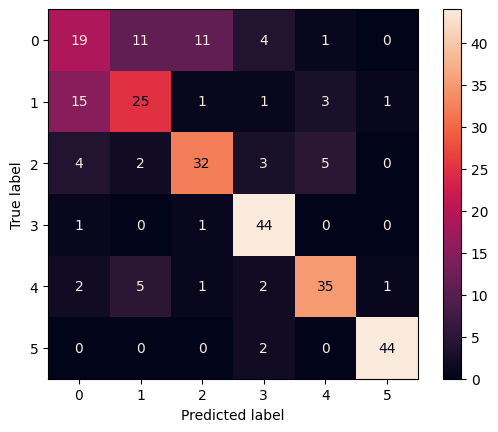

In [ ]:
report(y_pred_mobilenet, y_test)

## Each side train


### Left side

In [ ]:
model_mobilenet = models.Sequential()
model_mobilenet.add(layers.InputLayer(input_shape=(256, 256, 1)))
model_mobilenet.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))  # Convert grayscale to RGB
model_mobilenet.add(mobilenet)
model_mobilenet.add(layers.GlobalAveragePooling2D())
model_mobilenet.add(layers.Dense(6, activation='softmax'))  # Output layer
model_mobilenet.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])

Epoch 1/50
35/35 [==============================] - 6s 86ms/step - loss: 1.6343 - acc: 0.3474 - val_loss: 1.4130 - val_acc: 0.4720
Epoch 2/50
35/35 [==============================] - 1s 28ms/step - loss: 1.2003 - acc: 0.5783 - val_loss: 1.2298 - val_acc: 0.5520
Epoch 3/50
35/35 [==============================] - 1s 29ms/step - loss: 1.0652 - acc: 0.6088 - val_loss: 1.1650 - val_acc: 0.5760
Epoch 4/50
35/35 [==============================] - 1s 27ms/step - loss: 0.9983 - acc: 0.6213 - val_loss: 1.1231 - val_acc: 0.5520
Epoch 5/50
35/35 [==============================] - 1s 29ms/step - loss: 0.9499 - acc: 0.6732 - val_loss: 1.0839 - val_acc: 0.5120
Epoch 6/50
35/35 [==============================] - 1s 30ms/step - loss: 0.9204 - acc: 0.6714 - val_loss: 1.0589 - val_acc: 0.5520
Epoch 7/50
35/35 [==============================] - 1s 29ms/step - loss: 0.8985 - acc: 0.6723 - val_loss: 1.0529 - val_acc: 0.5760
Epoch 8/50
35/35 [==============================] - 1s 25ms/step - loss: 0.8681 - a

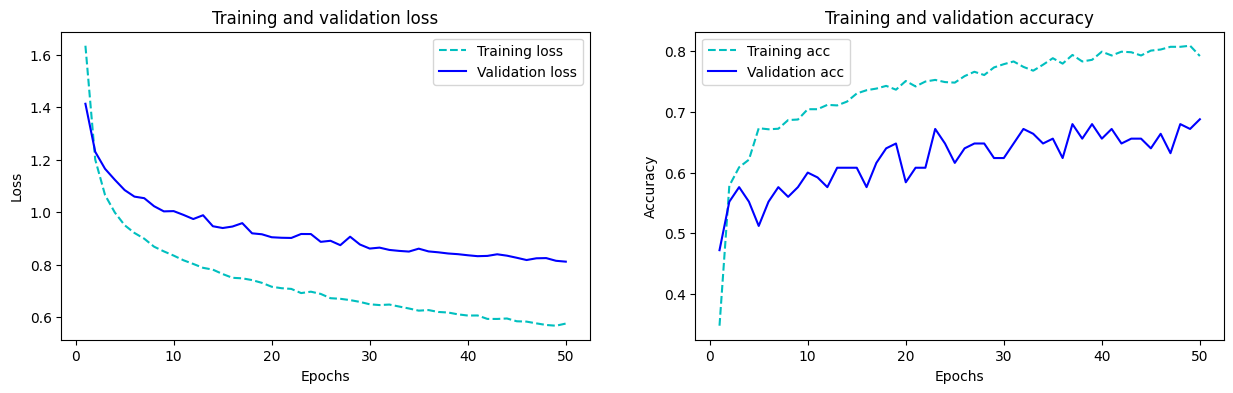

In [ ]:
history_mobilenet_left = model_mobilenet.fit(
    x_train_left, y_train_left,
    validation_data = (x_val_left,y_val_left),
    batch_size = 32, epochs= 50,
    callbacks = es)
show_result(history_mobilenet_left)

In [ ]:
y_pred_mobilenet_left = model_mobilenet.predict(x_test_left)
y_pred_mobilenet_left = np.argmax(y_pred_mobilenet_left, axis = 1)

5/5 [==============================] - 1s 148ms/step


              precision    recall  f1-score   support

     Normals       0.73      0.35      0.47        23
    Diabetes       0.47      0.61      0.53        23
    Glaucoma       0.61      0.87      0.71        23
    Cataract       0.88      0.91      0.89        23
 Age related       0.67      0.52      0.59        23
      Myopia       1.00      0.96      0.98        23

    accuracy                           0.70       138
   macro avg       0.72      0.70      0.69       138
weighted avg       0.72      0.70      0.69       138



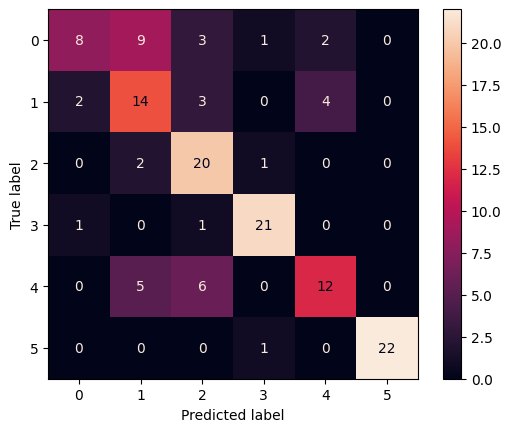

In [ ]:
report(y_pred_mobilenet_left, y_test_left)

### Right side

In [ ]:
model_mobilenet = models.Sequential()
model_mobilenet.add(layers.InputLayer(input_shape=(256, 256, 1)))
model_mobilenet.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))
model_mobilenet.add(mobilenet)
model_mobilenet.add(layers.GlobalAveragePooling2D())
model_mobilenet.add(layers.Dense(6, activation='softmax'))
model_mobilenet.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])

Epoch 1/50
35/35 [==============================] - 5s 58ms/step - loss: 1.7528 - acc: 0.2945 - val_loss: 1.4515 - val_acc: 0.4640
Epoch 2/50
35/35 [==============================] - 1s 26ms/step - loss: 1.2536 - acc: 0.5273 - val_loss: 1.2495 - val_acc: 0.5360
Epoch 3/50
35/35 [==============================] - 1s 25ms/step - loss: 1.0874 - acc: 0.5927 - val_loss: 1.1649 - val_acc: 0.5280
Epoch 4/50
35/35 [==============================] - 1s 30ms/step - loss: 1.0108 - acc: 0.6213 - val_loss: 1.1457 - val_acc: 0.5360
Epoch 5/50
35/35 [==============================] - 1s 31ms/step - loss: 0.9614 - acc: 0.6589 - val_loss: 1.1172 - val_acc: 0.5680
Epoch 6/50
35/35 [==============================] - 1s 31ms/step - loss: 0.9303 - acc: 0.6562 - val_loss: 1.0861 - val_acc: 0.5680
Epoch 7/50
35/35 [==============================] - 1s 31ms/step - loss: 0.9027 - acc: 0.6688 - val_loss: 1.0685 - val_acc: 0.5920
Epoch 8/50
35/35 [==============================] - 1s 29ms/step - loss: 0.8757 - a

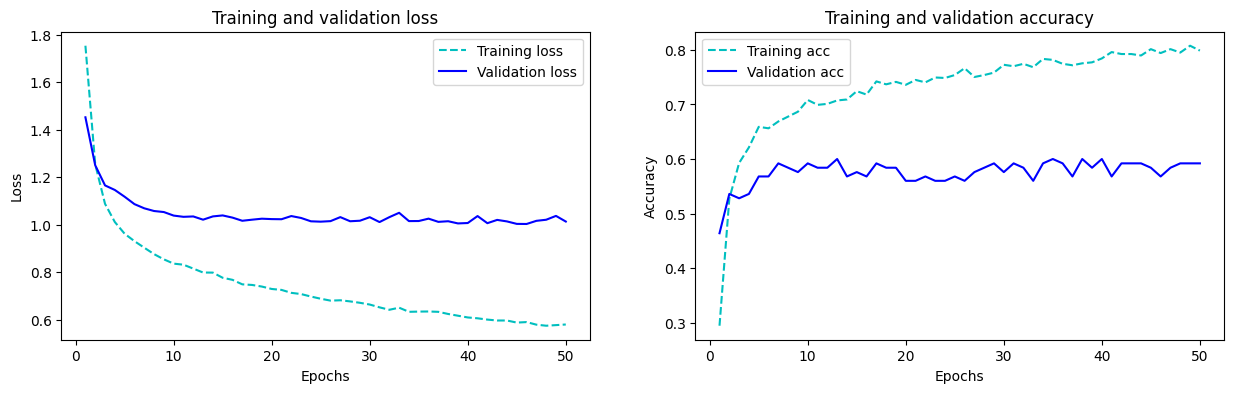

In [ ]:
history_mobilenet_right = model_mobilenet.fit(
    x_train_left,
    y_train_left,
    validation_data = (x_val_right,y_val_right),
    batch_size = 32,
    epochs= 50,
    callbacks=es)
show_result(history_mobilenet_right)

In [ ]:
y_pred_mobilenet_right = model_mobilenet.predict(x_test_right)
y_pred_mobilenet_right = np.argmax(y_pred_mobilenet_right, axis = 1)

5/5 [==============================] - 1s 19ms/step


              precision    recall  f1-score   support

     Normals       0.31      0.35      0.33        23
    Diabetes       0.41      0.39      0.40        23
    Glaucoma       0.62      0.65      0.64        23
    Cataract       0.80      0.87      0.83        23
 Age related       0.58      0.48      0.52        23
      Myopia       0.95      0.91      0.93        23

    accuracy                           0.61       138
   macro avg       0.61      0.61      0.61       138
weighted avg       0.61      0.61      0.61       138



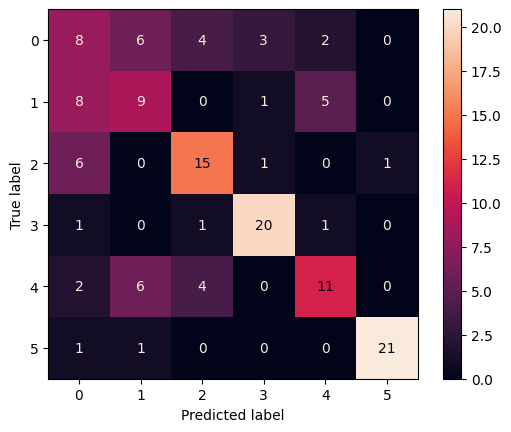

In [ ]:
report(y_pred_mobilenet_right, y_test_right)

# Model 3 CNN

## Both side same train

In [ ]:
cnn = models.Sequential()

cnn.add(layers.Conv2D(filters=32,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',
                      input_shape=(256, 256, 1),))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=32,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=64,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=64,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=128,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=128,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Flatten())

cnn.add(layers.Dense(128,activation='relu',
                     kernel_initializer='he_normal',))

cnn.add(layers.Dense(64,activation='relu',
                     kernel_initializer='he_normal',))

cnn.add(layers.Dropout(0.2))

cnn.add(layers.Dense(6,activation='softmax',
                     kernel_initializer='he_normal',))

cnn.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)       

Epoch 1/60
70/70 [==============================] - 10s 64ms/step - loss: 15.6665 - acc: 0.1991 - val_loss: 1.7020 - val_acc: 0.2570
Epoch 2/60
70/70 [==============================] - 3s 42ms/step - loss: 1.6619 - acc: 0.2899 - val_loss: 1.5912 - val_acc: 0.3614
Epoch 3/60
70/70 [==============================] - 3s 42ms/step - loss: 1.5481 - acc: 0.3593 - val_loss: 1.4355 - val_acc: 0.4137
Epoch 4/60
70/70 [==============================] - 3s 43ms/step - loss: 1.4533 - acc: 0.4309 - val_loss: 1.4323 - val_acc: 0.4016
Epoch 5/60
70/70 [==============================] - 3s 44ms/step - loss: 1.3231 - acc: 0.4832 - val_loss: 1.2549 - val_acc: 0.5301
Epoch 6/60
70/70 [==============================] - 3s 41ms/step - loss: 1.2211 - acc: 0.5365 - val_loss: 1.3342 - val_acc: 0.5060
Epoch 7/60
70/70 [==============================] - 3s 42ms/step - loss: 1.0931 - acc: 0.5709 - val_loss: 1.0385 - val_acc: 0.5823
Epoch 8/60
70/70 [==============================] - 3s 42ms/step - loss: 1.0294 -

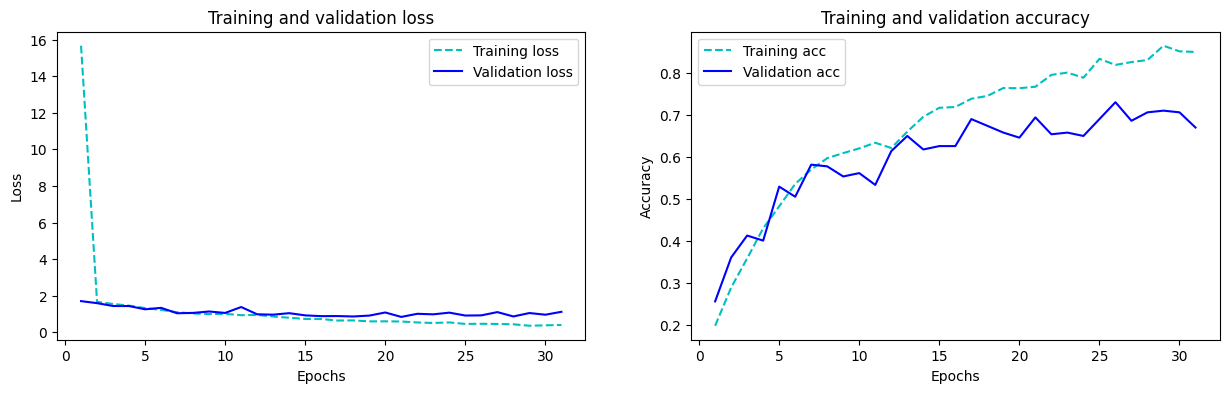

In [ ]:
history_cnn = cnn.fit(x_train,y_train,
                      batch_size=32,epochs=60,
                      validation_data=(x_val,y_val),
                      callbacks=es)
show_result(history_cnn)

In [ ]:
y_pred_CNN = cnn.predict(x_test)
y_pred_CNN = np.argmax(y_pred_CNN, axis = 1)

9/9 [==============================] - 1s 50ms/step


              precision    recall  f1-score   support

     Normals       0.39      0.41      0.40        46
    Diabetes       0.83      0.11      0.19        46
    Glaucoma       0.65      0.80      0.72        46
    Cataract       0.88      0.93      0.91        46
 Age related       0.64      0.89      0.75        46
      Myopia       0.90      1.00      0.95        46

    accuracy                           0.69       276
   macro avg       0.72      0.69      0.65       276
weighted avg       0.72      0.69      0.65       276



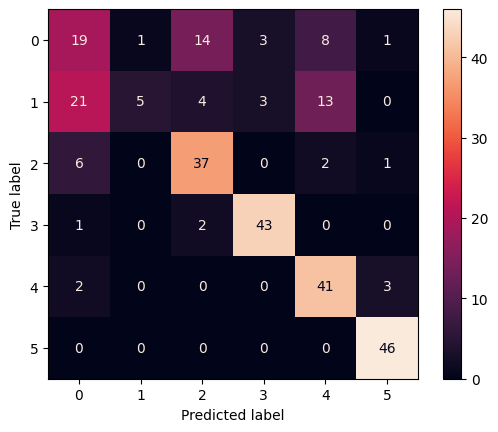

In [ ]:
report(y_pred_CNN,y_test)

## Each side train


### Left side

In [ ]:
cnn = models.Sequential()

cnn.add(layers.Conv2D(filters=32,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',
                      input_shape=(256, 256, 1),))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=32,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal'))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=64,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=64,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=128,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=128,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Flatten())

cnn.add(layers.Dense(128,activation='relu',
                     kernel_initializer='he_normal',))

cnn.add(layers.Dense(64,activation='relu',
                     kernel_initializer='he_normal',))

cnn.add(layers.Dropout(0.2))

cnn.add(layers.Dense(6,activation='softmax',
                     kernel_initializer='he_normal',))

cnn.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 32, 32, 64)       

Epoch 1/60
35/35 [==============================] - 5s 80ms/step - loss: 45.2073 - acc: 0.1683 - val_loss: 1.8184 - val_acc: 0.2000
Epoch 2/60
35/35 [==============================] - 2s 43ms/step - loss: 1.7880 - acc: 0.2677 - val_loss: 1.6515 - val_acc: 0.3360
Epoch 3/60
35/35 [==============================] - 2s 44ms/step - loss: 1.5693 - acc: 0.3518 - val_loss: 1.6308 - val_acc: 0.3520
Epoch 4/60
35/35 [==============================] - 2s 44ms/step - loss: 1.4261 - acc: 0.4288 - val_loss: 1.4859 - val_acc: 0.4000
Epoch 5/60
35/35 [==============================] - 2s 44ms/step - loss: 1.3325 - acc: 0.4763 - val_loss: 1.4988 - val_acc: 0.3840
Epoch 6/60
35/35 [==============================] - 2s 43ms/step - loss: 1.2305 - acc: 0.5246 - val_loss: 1.3124 - val_acc: 0.4880
Epoch 7/60
35/35 [==============================] - 1s 42ms/step - loss: 1.1052 - acc: 0.5506 - val_loss: 1.3165 - val_acc: 0.5040
Epoch 8/60
35/35 [==============================] - 1s 42ms/step - loss: 1.0199 - 

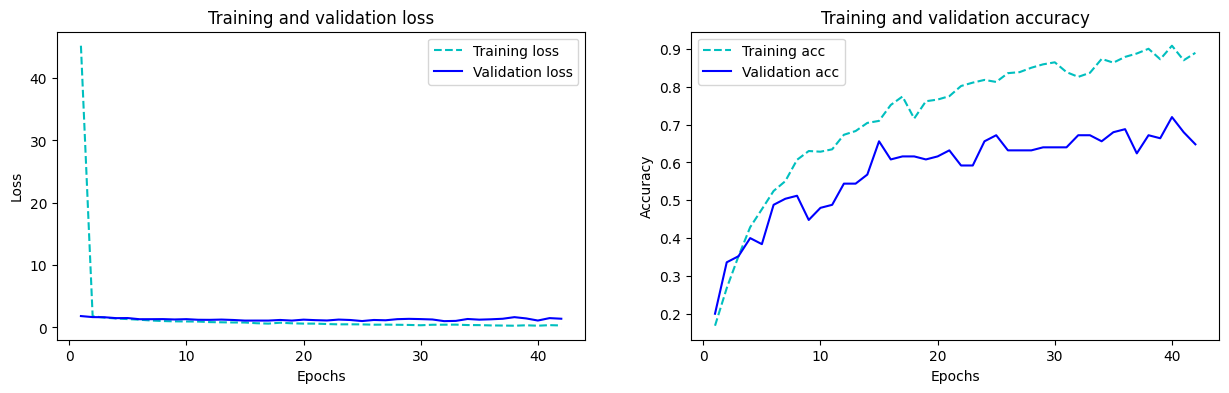

In [ ]:
history_cnn_left = cnn.fit(x_train_left,y_train_left,
                           batch_size=32,epochs=60,
                           validation_data=(x_val_left,y_val_left),
                           callbacks=es)

show_result(history_cnn_left)

In [ ]:
y_pred_CNN_left = cnn.predict(x_test_left)
y_pred_CNN_left = np.argmax(y_pred_CNN_left, axis = 1)

5/5 [==============================] - 0s 77ms/step


              precision    recall  f1-score   support

     Normals       0.75      0.52      0.62        23
    Diabetes       0.68      0.57      0.62        23
    Glaucoma       0.75      0.91      0.82        23
    Cataract       0.88      0.91      0.89        23
 Age related       0.76      0.96      0.85        23
      Myopia       1.00      0.96      0.98        23

    accuracy                           0.80       138
   macro avg       0.80      0.80      0.80       138
weighted avg       0.80      0.80      0.80       138



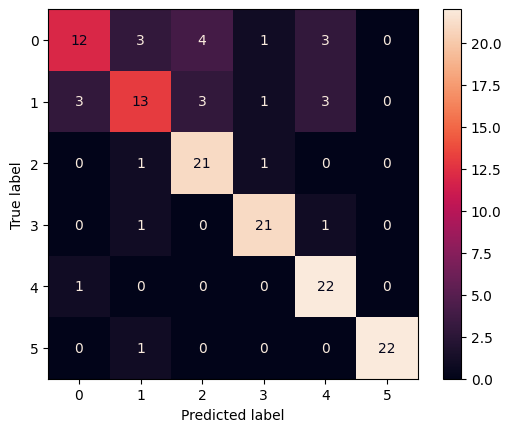

In [ ]:
report(y_pred_CNN_left,y_test_left)

### Right side

In [ ]:
cnn = models.Sequential()

cnn.add(layers.Conv2D(filters=32,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',
                      input_shape=(256, 256, 1),))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=32,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=64,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=64,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=128,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Conv2D(filters=128,kernel_size=3,
                      padding='same',activation = 'relu',
                      kernel_initializer='he_normal',))

cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Flatten())

cnn.add(layers.Dense(128,activation='relu',
                     kernel_initializer='he_normal',))

cnn.add(layers.Dense(64,activation='relu',
                     kernel_initializer='he_normal',))

cnn.add(layers.Dropout(0.2))

cnn.add(layers.Dense(6,activation='softmax',
                     kernel_initializer='he_normal',))

cnn.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])
cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 32, 32, 64)       

Epoch 1/60
35/35 [==============================] - 5s 53ms/step - loss: 31.1160 - acc: 0.1746 - val_loss: 1.8604 - val_acc: 0.1680
Epoch 2/60
35/35 [==============================] - 1s 41ms/step - loss: 1.7577 - acc: 0.2757 - val_loss: 1.6463 - val_acc: 0.3760
Epoch 3/60
35/35 [==============================] - 1s 41ms/step - loss: 1.6196 - acc: 0.3303 - val_loss: 1.5227 - val_acc: 0.4000
Epoch 4/60
35/35 [==============================] - 1s 42ms/step - loss: 1.5262 - acc: 0.3823 - val_loss: 1.5079 - val_acc: 0.4640
Epoch 5/60
35/35 [==============================] - 1s 41ms/step - loss: 1.4805 - acc: 0.3993 - val_loss: 1.4962 - val_acc: 0.4240
Epoch 6/60
35/35 [==============================] - 1s 42ms/step - loss: 1.4094 - acc: 0.4369 - val_loss: 1.5194 - val_acc: 0.4080
Epoch 7/60
35/35 [==============================] - 1s 41ms/step - loss: 1.3342 - acc: 0.4790 - val_loss: 1.5190 - val_acc: 0.4480
Epoch 8/60
35/35 [==============================] - 1s 43ms/step - loss: 1.2703 - 

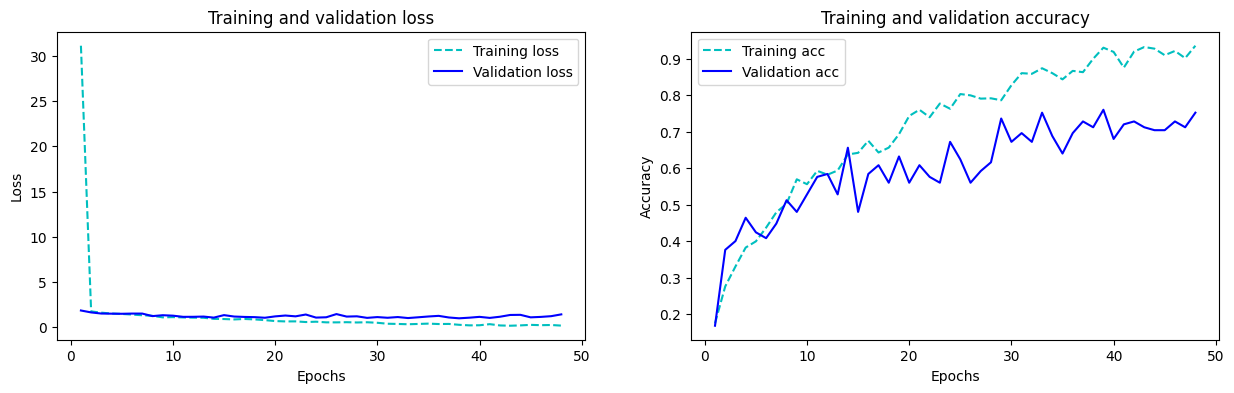

In [ ]:
history_cnn_right = cnn.fit(x_train_right,y_train_right,
                            batch_size=32,epochs=60,
                            validation_data=(x_val_right,y_val_right),
                            callbacks=es)

show_result(history_cnn_right)

In [ ]:
y_pred_CNN_right = cnn.predict(x_test_right)
y_pred_CNN_right = np.argmax(y_pred_CNN_right, axis = 1)

5/5 [==============================] - 0s 12ms/step


              precision    recall  f1-score   support

     Normals       0.40      0.43      0.42        23
    Diabetes       0.69      0.48      0.56        23
    Glaucoma       0.80      0.87      0.83        23
    Cataract       0.81      0.96      0.88        23
 Age related       0.84      0.70      0.76        23
      Myopia       0.88      1.00      0.94        23

    accuracy                           0.74       138
   macro avg       0.74      0.74      0.73       138
weighted avg       0.74      0.74      0.73       138



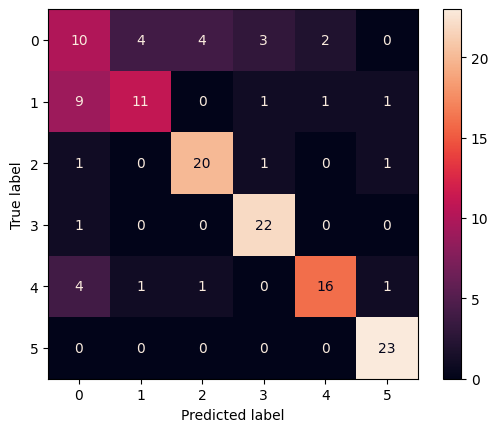

In [ ]:
report(y_pred_CNN_right,y_test_right)

# Model 4 VGG16

## Both side same train

In [ ]:
# load vgg16 model
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False,weights= None, input_shape=(256, 256, 1))

for layer in vgg.layers:
  layer.trainable = False

model_vgg = models.Sequential()

model_vgg.add(layers.InputLayer(input_shape=(256, 256, 1)))
model_vgg.add(vgg)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_vgg.add(layers.Dropout(0.25))
model_vgg.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))


model_vgg.add(layers.Dense(6, activation='softmax'))
model_vgg.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])

model_vgg.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14713536  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 6)                 774       
                                                                 
Total params: 18925254 (72.19 MB)
Trainable params: 42

Epoch 1/60
70/70 [==============================] - 24s 275ms/step - loss: 1.8541 - acc: 0.2188 - val_loss: 1.6658 - val_acc: 0.2811
Epoch 2/60
70/70 [==============================] - 12s 170ms/step - loss: 1.6677 - acc: 0.2828 - val_loss: 1.6132 - val_acc: 0.2811
Epoch 3/60
70/70 [==============================] - 12s 172ms/step - loss: 1.6055 - acc: 0.3141 - val_loss: 1.5395 - val_acc: 0.3534
Epoch 4/60
70/70 [==============================] - 12s 172ms/step - loss: 1.5825 - acc: 0.3275 - val_loss: 1.5336 - val_acc: 0.3574
Epoch 5/60
70/70 [==============================] - 12s 172ms/step - loss: 1.5387 - acc: 0.3530 - val_loss: 1.4754 - val_acc: 0.4137
Epoch 6/60
70/70 [==============================] - 12s 173ms/step - loss: 1.5085 - acc: 0.3647 - val_loss: 1.4257 - val_acc: 0.4096
Epoch 7/60
70/70 [==============================] - 12s 173ms/step - loss: 1.4680 - acc: 0.3852 - val_loss: 1.3973 - val_acc: 0.4096
Epoch 8/60
70/70 [==============================] - 12s 174ms/step - 

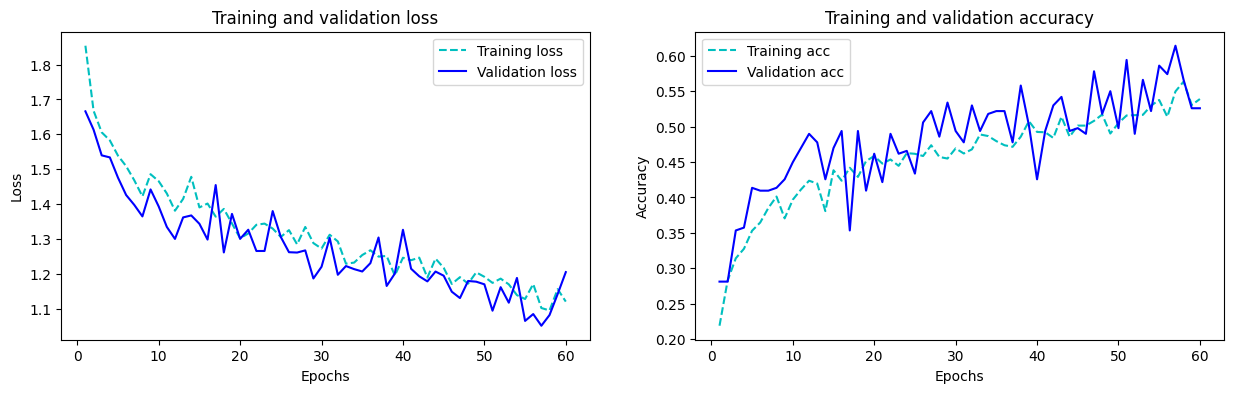

In [ ]:
history_vgg = model_vgg.fit(x_train,y_train,
                      batch_size=32,epochs=60,
                      validation_data=(x_val,y_val),
                      callbacks=es)
show_result(history_vgg)

In [ ]:
y_pred_VGG = model_vgg.predict(x_test)
y_pred_VGG = np.argmax(y_pred_VGG, axis = 1)

9/9 [==============================] - 4s 511ms/step


              precision    recall  f1-score   support

     Normals       0.22      0.24      0.23        46
    Diabetes       0.40      0.46      0.43        46
    Glaucoma       0.53      0.67      0.60        46
    Cataract       0.66      0.83      0.73        46
 Age related       0.31      0.24      0.27        46
      Myopia       1.00      0.46      0.63        46

    accuracy                           0.48       276
   macro avg       0.52      0.48      0.48       276
weighted avg       0.52      0.48      0.48       276



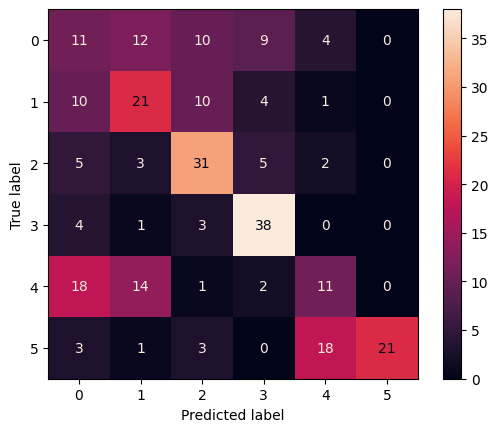

In [ ]:
report(y_pred_VGG,y_test)

## Each side train


### Left side

In [ ]:
# load vgg16 model
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False,weights= None, input_shape=(256, 256, 1))

for layer in vgg.layers:
  layer.trainable = False

model_vgg = models.Sequential()

model_vgg.add(layers.InputLayer(input_shape=(256, 256, 1)))
model_vgg.add(vgg)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_vgg.add(layers.Dropout(0.25))
model_vgg.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))


model_vgg.add(layers.Dense(6, activation='softmax'))
model_vgg.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])

model_vgg.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14713536  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_18 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 6)                 774       
                                                                 
Total params: 18925254 (72.19 MB)
Trainable params: 4

Epoch 1/60
35/35 [==============================] - 11s 283ms/step - loss: 2.2212 - acc: 0.1817 - val_loss: 1.7941 - val_acc: 0.1520
Epoch 2/60
35/35 [==============================] - 6s 179ms/step - loss: 1.7241 - acc: 0.2722 - val_loss: 1.7452 - val_acc: 0.2800
Epoch 3/60
35/35 [==============================] - 6s 179ms/step - loss: 1.6489 - acc: 0.3026 - val_loss: 1.6480 - val_acc: 0.3760
Epoch 4/60
35/35 [==============================] - 6s 179ms/step - loss: 1.5842 - acc: 0.3438 - val_loss: 1.6519 - val_acc: 0.3520
Epoch 5/60
35/35 [==============================] - 6s 180ms/step - loss: 1.5923 - acc: 0.3098 - val_loss: 1.5716 - val_acc: 0.3840
Epoch 6/60
35/35 [==============================] - 6s 180ms/step - loss: 1.5252 - acc: 0.3653 - val_loss: 1.5770 - val_acc: 0.3760
Epoch 7/60
35/35 [==============================] - 6s 179ms/step - loss: 1.4861 - acc: 0.3662 - val_loss: 1.5781 - val_acc: 0.3840
Epoch 8/60
35/35 [==============================] - 6s 179ms/step - loss: 1

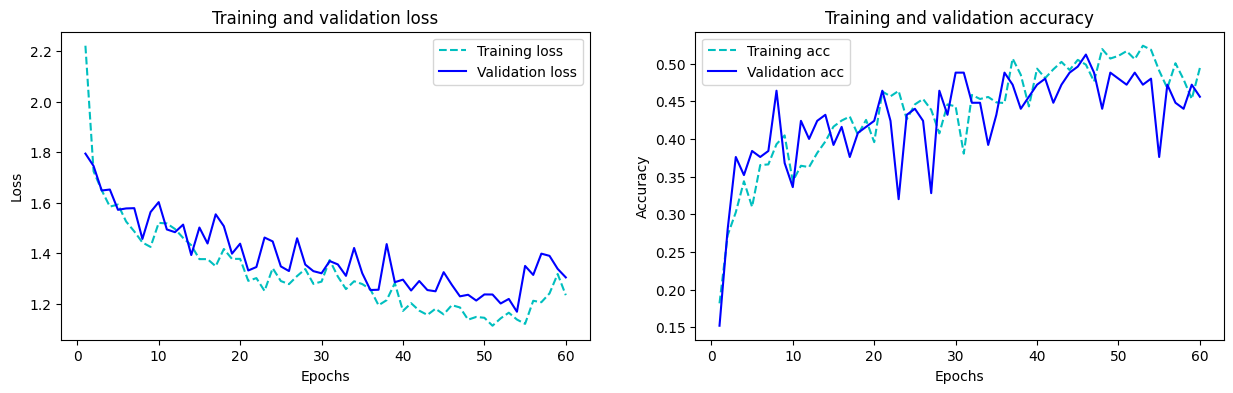

In [ ]:
history_vgg_left = model_vgg.fit(x_train_left,y_train_left,
                      batch_size=32,epochs=60,
                      validation_data=(x_val_left,y_val_left),
                      callbacks=es)
show_result(history_vgg_left)

In [ ]:
y_pred_VGG_left = model_vgg.predict(x_test_left)
y_pred_VGG_left = np.argmax(y_pred_VGG_left, axis = 1)

5/5 [==============================] - 2s 566ms/step


              precision    recall  f1-score   support

     Normals       0.67      0.26      0.38        23
    Diabetes       0.34      0.57      0.43        23
    Glaucoma       0.79      0.48      0.59        23
    Cataract       0.63      0.96      0.76        23
 Age related       0.30      0.30      0.30        23
      Myopia       1.00      0.83      0.90        23

    accuracy                           0.57       138
   macro avg       0.62      0.57      0.56       138
weighted avg       0.62      0.57      0.56       138



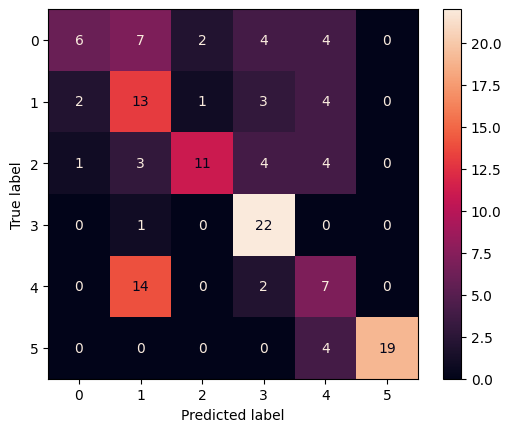

In [ ]:
report(y_pred_VGG_left,y_test_left)

### Right side

In [ ]:
# load vgg16 model
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False,weights= None, input_shape=(256, 256, 1))

for layer in vgg.layers:
  layer.trainable = False

model_vgg = models.Sequential()

model_vgg.add(layers.InputLayer(input_shape=(256, 256, 1)))
model_vgg.add(vgg)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_vgg.add(layers.Dropout(0.25))
model_vgg.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))


model_vgg.add(layers.Dense(6, activation='softmax'))
model_vgg.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])

model_vgg.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14713536  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_21 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 6)                 774       
                                                                 
Total params: 18925254 (72.19 MB)
Trainable params: 4

Epoch 1/60
35/35 [==============================] - 8s 184ms/step - loss: 2.0806 - acc: 0.1826 - val_loss: 1.7214 - val_acc: 0.2480
Epoch 2/60
35/35 [==============================] - 6s 174ms/step - loss: 1.7174 - acc: 0.2569 - val_loss: 1.6896 - val_acc: 0.3040
Epoch 3/60
35/35 [==============================] - 6s 177ms/step - loss: 1.6811 - acc: 0.2614 - val_loss: 1.6626 - val_acc: 0.3120
Epoch 4/60
35/35 [==============================] - 7s 200ms/step - loss: 1.6684 - acc: 0.2883 - val_loss: 1.6519 - val_acc: 0.2400
Epoch 5/60
35/35 [==============================] - 7s 201ms/step - loss: 1.6492 - acc: 0.2766 - val_loss: 1.6316 - val_acc: 0.3360
Epoch 6/60
35/35 [==============================] - 6s 185ms/step - loss: 1.5986 - acc: 0.3196 - val_loss: 1.6096 - val_acc: 0.2560
Epoch 7/60
35/35 [==============================] - 6s 183ms/step - loss: 1.6055 - acc: 0.3035 - val_loss: 1.6351 - val_acc: 0.3280
Epoch 8/60
35/35 [==============================] - 7s 200ms/step - loss: 1.

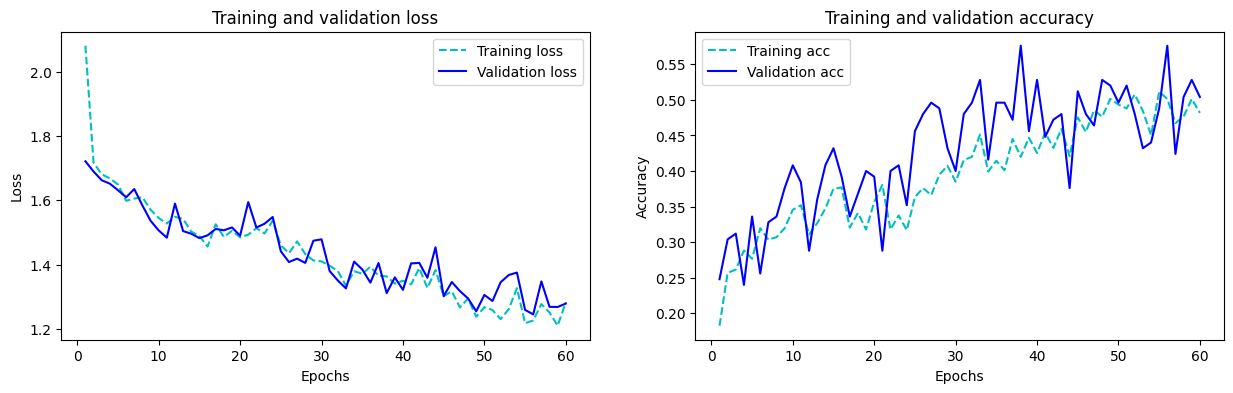

In [ ]:
history_vgg_right = model_vgg.fit(x_train_right,y_train_right,
                      batch_size=32,epochs=60,
                      validation_data=(x_val_right,y_val_right),
                      callbacks=es)
show_result(history_vgg_right)

In [ ]:
y_pred_VGG_right = model_vgg.predict(x_test_right)
y_pred_VGG_right = np.argmax(y_pred_VGG_right, axis = 1)

5/5 [==============================] - 1s 161ms/step


              precision    recall  f1-score   support

     Normals       0.21      0.26      0.23        23
    Diabetes       0.50      0.04      0.08        23
    Glaucoma       0.61      0.61      0.61        23
    Cataract       0.43      0.96      0.59        23
 Age related       0.44      0.30      0.36        23
      Myopia       0.94      0.70      0.80        23

    accuracy                           0.48       138
   macro avg       0.52      0.48      0.45       138
weighted avg       0.52      0.48      0.45       138



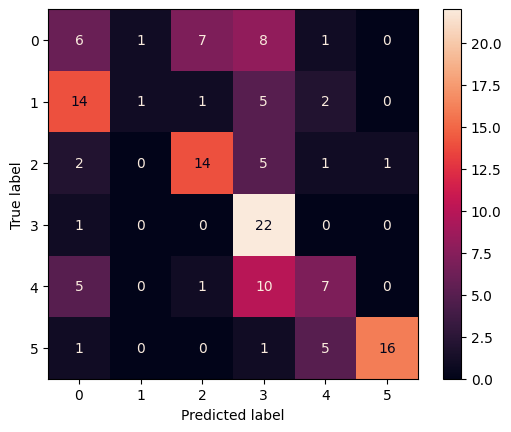

In [ ]:
report(y_pred_VGG_right,y_test_right)

# Model 5 Random Forest

## Both side same train

In [ ]:
nsamples, nx, ny, nrgb = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny*nrgb))

In [ ]:
nsamples, nx, ny, nrgb = x_val.shape
x_val = x_val.reshape((nsamples,nx*ny*nrgb))

In [ ]:
nsamples, nx, ny, nrgb = x_test.shape
x_test = x_test.reshape((nsamples,nx*ny*nrgb))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
rf_classifier=RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'min_samples_leaf': 1, 'n_estimators': 100}


In [ ]:
best_rf_classifier = grid_search.best_estimator_
history = best_rf_classifier.fit(x_train, y_train)


In [ ]:
y_pred = best_rf_classifier.predict(x_test)

              precision    recall  f1-score   support

     Normals       0.53      0.46      0.49        46
    Diabetes       0.57      0.59      0.58        46
    Glaucoma       0.83      0.83      0.83        46
    Cataract       0.79      0.89      0.84        46
 Age related       0.83      0.85      0.84        46
      Myopia       1.00      0.96      0.98        46

    accuracy                           0.76       276
   macro avg       0.76      0.76      0.76       276
weighted avg       0.76      0.76      0.76       276



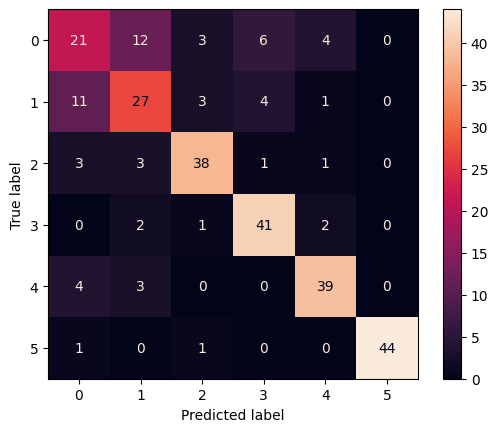

In [ ]:
report(y_pred,y_test)

## Each side train

### Right

In [ ]:
nsamples, nx, ny, nrgb = x_train_right.shape
x_train_right = x_train_right.reshape((nsamples,nx*ny*nrgb))

In [ ]:
nsamples, nx, ny, nrgb = x_val_right.shape
x_val_right = x_val_right.reshape((nsamples,nx*ny*nrgb))

In [ ]:
nsamples, nx, ny, nrgb = x_test_right.shape
x_test_right = x_test_right.reshape((nsamples,nx*ny*nrgb))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
rf_classifier=RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_right, y_train_right)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'min_samples_leaf': 1, 'n_estimators': 150}


In [ ]:
best_rf_classifier = grid_search.best_estimator_
history = best_rf_classifier.fit(x_train_right, y_train_right)

In [ ]:
y_pred = best_rf_classifier.predict(x_test_right)

              precision    recall  f1-score   support

     Normals       0.48      0.43      0.45        23
    Diabetes       0.60      0.65      0.63        23
    Glaucoma       0.87      0.87      0.87        23
    Cataract       0.92      1.00      0.96        23
 Age related       0.86      0.78      0.82        23
      Myopia       0.96      0.96      0.96        23

    accuracy                           0.78       138
   macro avg       0.78      0.78      0.78       138
weighted avg       0.78      0.78      0.78       138



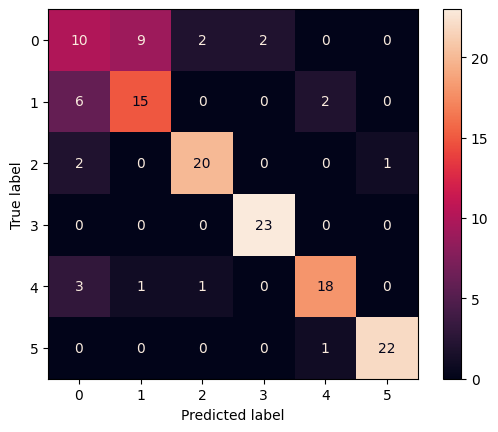

In [ ]:
report(y_pred,y_test_right)

### Left

In [ ]:
nsamples, nx, ny, nrgb = x_train_left.shape
x_train_left = x_train_left.reshape((nsamples,nx*ny*nrgb))

In [ ]:
nsamples, nx, ny, nrgb = x_val_left.shape
x_val_left = x_val_left.reshape((nsamples,nx*ny*nrgb))

In [ ]:
nsamples, nx, ny, nrgb = x_test_left.shape
x_test_left = x_test_left.reshape((nsamples,nx*ny*nrgb))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
rf_classifier=RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_left, y_train_left)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'min_samples_leaf': 1, 'n_estimators': 50}


In [ ]:
best_rf_classifier = grid_search.best_estimator_
history = best_rf_classifier.fit(x_train_left, y_train_left)


In [ ]:
y_pred = best_rf_classifier.predict(x_test_left)

              precision    recall  f1-score   support

     Normals       0.53      0.35      0.42        23
    Diabetes       0.64      0.70      0.67        23
    Glaucoma       0.79      0.83      0.81        23
    Cataract       0.88      1.00      0.94        23
 Age related       0.83      0.87      0.85        23
      Myopia       0.88      0.91      0.89        23

    accuracy                           0.78       138
   macro avg       0.76      0.78      0.76       138
weighted avg       0.76      0.78      0.76       138



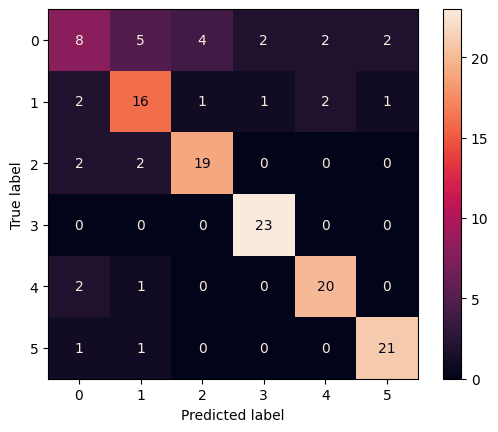

In [ ]:
report(y_pred,y_test_left)